In [13]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.datasets import CIFAR100
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import torchvision.models as models
import numpy as np

In [14]:
train_set = CIFAR100(root='/', download=True, train=True)

Files already downloaded and verified


In [15]:
# Stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(train_set[i][0]) for i in range(len(train_set))])

# calculate the mean and std along the (0, 1) axes
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255
# the the mean and std
mean=mean.tolist()
std=std.tolist()

In [16]:
transform_train = tt.Compose([tt.RandomCrop(32, padding=4,padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(mean,std,inplace=True)])
transform_test = tt.Compose([tt.ToTensor(), tt.Normalize(mean,std)])

In [17]:
train_set = CIFAR100(root='/', download=True, train=True, transform=transform_train)
train_set, val_set = torch.utils.data.random_split(train_set, [0.8, 0.2])
test_set = CIFAR100(root='/', download=True, train=False, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)

In [19]:
# ResNet9
def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Resnet9(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

        self.fc = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 100)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.fc(x)
        return x


In [20]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Resnet9().to(device)

lr=1e-3
weight_decay=1e-2
criterion=nn.CrossEntropyLoss()

optimizer=optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


In [21]:
def train(epochs):
    val_losses = []
    train_losses = []

    for epoch_num in range(epochs):
        model.train()

        epoch_losses = 0

        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_preds = model(batch_x)

            loss = criterion(batch_y_preds, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses += (len(batch_y)*loss.item())

        epoch_loss = epoch_losses/len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        correctly_labelled = 0
        with torch.no_grad():
            val_epoch_losses = 0
            for val_batch_x, val_batch_y in val_loader:
                val_batch_x = val_batch_x.to(device)
                val_batch_y = val_batch_y.to(device)

                val_batch_y_preds = model(val_batch_x)
                val_loss = criterion(val_batch_y_preds, val_batch_y)
                val_epoch_losses += (len(val_batch_y)*val_loss.item())

                correctly_labelled += (val_batch_y_preds.argmax(dim=1) == val_batch_y).sum().item()

            val_epoch_loss = val_epoch_losses/len(val_loader.dataset)
            val_losses.append(val_epoch_loss)
        scheduler.step()
        print(f'Epoch: {epoch_num+1}/{epochs}, learning_rate={scheduler.get_last_lr()} train_loss={epoch_loss:.2f}, val_loss={val_epoch_loss:.2f}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100:.2f}% accuracy)')
    print('Training Done')
    return train_losses, val_losses


In [22]:
train_losses = []
val_losses = []

cycle_train_losses, cycle_val_losses = train(20)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

Epoch: 1/20, learning_rate=[0.00095] train_loss=3.93, val_loss=3.72. labelled 1196/10000 correctly (11.96% accuracy)
Epoch: 2/20, learning_rate=[0.0009025] train_loss=3.24, val_loss=3.33. labelled 1863/10000 correctly (18.63% accuracy)
Epoch: 3/20, learning_rate=[0.000857375] train_loss=2.84, val_loss=3.67. labelled 1609/10000 correctly (16.09% accuracy)
Epoch: 4/20, learning_rate=[0.0008145062499999999] train_loss=2.62, val_loss=3.06. labelled 2436/10000 correctly (24.36% accuracy)
Epoch: 5/20, learning_rate=[0.0007737809374999998] train_loss=2.46, val_loss=2.96. labelled 2637/10000 correctly (26.37% accuracy)
Epoch: 6/20, learning_rate=[0.0007350918906249997] train_loss=2.34, val_loss=2.84. labelled 2778/10000 correctly (27.78% accuracy)
Epoch: 7/20, learning_rate=[0.0006983372960937497] train_loss=2.24, val_loss=2.67. labelled 3157/10000 correctly (31.57% accuracy)
Epoch: 8/20, learning_rate=[0.0006634204312890621] train_loss=2.16, val_loss=2.91. labelled 3056/10000 correctly (30.56

In [23]:
cycle_train_losses, cycle_val_losses = train(10)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

Epoch: 1/10, learning_rate=[0.0003405616262881147] train_loss=1.42, val_loss=1.69. labelled 5313/10000 correctly (53.13% accuracy)
Epoch: 2/10, learning_rate=[0.00032353354497370894] train_loss=1.38, val_loss=1.86. labelled 5019/10000 correctly (50.19% accuracy)
Epoch: 3/10, learning_rate=[0.00030735686772502346] train_loss=1.34, val_loss=1.99. labelled 4710/10000 correctly (47.10% accuracy)
Epoch: 4/10, learning_rate=[0.00029198902433877225] train_loss=1.31, val_loss=1.61. labelled 5558/10000 correctly (55.58% accuracy)
Epoch: 5/10, learning_rate=[0.00027738957312183364] train_loss=1.27, val_loss=1.62. labelled 5565/10000 correctly (55.65% accuracy)
Epoch: 6/10, learning_rate=[0.0002635200944657419] train_loss=1.23, val_loss=1.63. labelled 5515/10000 correctly (55.15% accuracy)
Epoch: 7/10, learning_rate=[0.0002503440897424548] train_loss=1.20, val_loss=1.65. labelled 5427/10000 correctly (54.27% accuracy)
Epoch: 8/10, learning_rate=[0.00023782688525533205] train_loss=1.16, val_loss=1

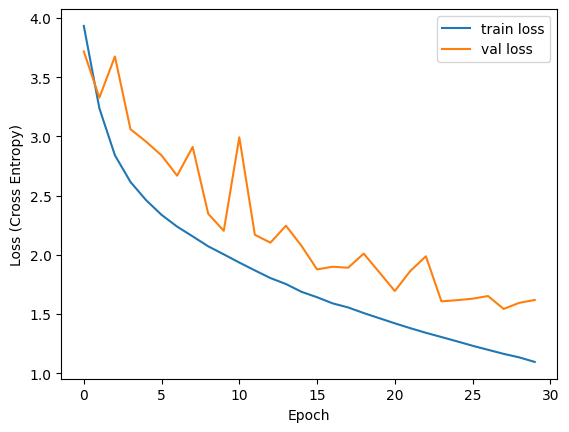

In [24]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()

In [25]:
model.eval()
correctly_labelled = 0
with torch.no_grad():
    val_epoch_losses = 0
    for test_batch_x, test_batch_y in test_loader:
        test_batch_x = test_batch_x.to(device)
        test_batch_y = test_batch_y.to(device)

        test_batch_y_preds = model(test_batch_x)
        test_loss = criterion(test_batch_y_preds, test_batch_y)

        correctly_labelled += (test_batch_y_preds.argmax(dim=1) == test_batch_y).sum().item()

    test_epoch_loss = val_epoch_losses/len(test_loader.dataset)
    print(f'Labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')


Labelled 5653/10000 correctly (56.53% accuracy)


In [26]:
print(model)

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr